In [3]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import pandas as pd
%matplotlib inline

from datetime import datetime, timedelta
import seaborn as sns

from global_config import config

data_dir      = config.get_property('covid_fb')
geo_dir       = config.get_property('geo_dir')
results_dir   = config.get_property('results_dir')


In [4]:
# Loads the rt
df_rt = pd.read_csv( os.path.join(results_dir, 'rt_merged_all.csv'),  parse_dates = ['date'])
df_rt['poly_id'] = df_rt.region.apply(lambda s: s.lower().replace('í','i').replace('ó','o').replace('á','a').replace('é','e').replace('ñ','n').replace(' ','_'))
df_rt.sample(10)

Unnamed: 0       date    median      mean  lower_90  lower_50  lower_20  \
1238          23 2020-04-07  1.237617  1.236227  1.154769  1.207197  1.226924   
1145         239 2020-11-07  1.041166  1.039236  0.970505  1.013832  1.030825   
5549          57 2020-05-22  1.112054  1.110668  1.062137  1.092096  1.104907   
3546         196 2020-09-29  0.970261  0.970027  0.923792  0.951902  0.963158   
5380         204 2020-09-26  1.013640  1.012542  0.951759  0.989522  1.004814   
5709         217 2020-10-29  1.029033  1.030483  0.992227  1.013359  1.023010   
4558         302 2021-01-09  0.893314  0.894858  0.835658  0.870849  0.884758   
5421         245 2020-11-06  1.043556  1.044116  0.990684  1.021449  1.035133   
5190          14 2020-03-20  1.419150  1.424328  1.299011  1.367445  1.397642   
643           38 2020-04-28  1.167239  1.169864  1.110045  1.141098  1.156328   

      upper_20  upper_50  upper_90              region  region_id  \
1238  1.248347  1.266923  1.314152      Ciudad Bolívar         19   
1145  1.051745  1.066945  1.099515           Chapinero          2   
5549  1.118710  1.129920  1.154520                Usme          5   
3546  0.977068  0.987596  1.016187  Rafael Uribe Uribe         18   
5380  1.021352  1.035613  1.070027             Usaquén          1   
5709  1.035174  1.045569  1.075591                Usme          5   
4558  0.902583  0.918873  0.956626                Suba         11   
5421  1.051334  1.065448  1.103308             Usaquén          1   
5190  1.437973  1.474891  1.574517             Usaquén          1   
643   1.177282  1.194358  1.242869                Bosa          7   

                 poly_id  
1238      ciudad_bolivar  
1145           chapinero  
5549                usme  
3546  rafael_uribe_uribe  
5380             usaquen  
5709                usme  
4558                suba  
5421             usaquen  
5190             usaquen  
643                 bosa

In [5]:

df_movement = pd.read_csv(os.path.join(results_dir,'data', 'movement_fb','movement.csv'), parse_dates = ['date_time'])



In [6]:
def read_geo_df(path_to_geodf):
    df_geo = pd.read_csv(path_to_geodf)
    df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)
    df_geo = gpd.GeoDataFrame(df_geo, geometry='geometry')
    return df_geo

In [11]:
from shapely.geometry import Point, LineString
from shapely.ops import cascaded_union

from datetime import timedelta
import contextily as ctx

import geopandas as gpd
from shapely import wkt

#movement_manz_df = pd.read_csv(  os.path.join(data_dir, 'agglomerated', 'geometry (sectores)', 'movement.csv'), parse_dates = ['date_time'])
#sec_poly_df      = read_geo_df( os.path.join(data_dir, 'agglomerated', 'geometry (sectores)', 'polygons.csv' )  )
#
#loc_poly_df      = read_geo_df( os.path.join(data_dir, 'agglomerated', 'geometry', 'polygons.csv')  )
#
#sec_poly_df      = sec_poly_df[["poly_id", "poly_name", "attr_population",	"attr_area", "geometry"]]
#loc_poly_df      = loc_poly_df[["poly_id", "poly_name", "geometry"]]
#
## Change name so it matches other places name there.
#loc_poly_df["poly_name_format"] = loc_poly_df["poly_id"].apply(lambda x: x.replace('colombia_bogota_localidad_', ''))


# from matplotlib import transforms
# fig, ax = plt.subplots(1, 1, figsize=(15.5, 15.2))
#
# base = ax.figure.gca().transData
# rot = transforms.Affine2D().rotate_deg(90)
#
# sec_poly_df.plot(ax=ax, alpha=0.5, color='r', transform= rot + base)
# loc_poly_df.plot(ax=ax, alpha=0.5, color='k', transform= rot + base)
# plt.show()

In [13]:
dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}


# read and rename localities
df_movement_localities = pd.read_csv(os.path.join(results_dir,'data', 'movement_fb_locality','movement.csv'), parse_dates = ['date_time'])
df_movement_localities["start_poly_id"] = df_movement_localities.start_poly_id.apply(lambda s: ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
df_movement_localities["end_poly_id"]   = df_movement_localities.end_poly_id.apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
df_movement_localities = df_movement_localities.replace( dict_correct )

# Creates type
df_movement_localities["movement_type"] = "External"
df_movement_localities.loc[df_movement_localities.start_poly_id == df_movement_localities.end_poly_id, "movement_type"] = "Internal"

# Consolidates dataframe
d1 = df_movement_localities.loc[df_movement_localities.movement_type == "External",['date_time','start_poly_id', 'movement','movement_type']]
d1.rename(columns= {'start_poly_id':'poly_id'}, inplace = True)

df_movement_localities

date_time   start_poly_id     end_poly_id  movement movement_type
0     2020-04-12  Barrios Unidos  Barrios Unidos     28117      Internal
1     2020-04-12  Barrios Unidos            Bosa       144      External
2     2020-04-12  Barrios Unidos       Chapinero       133      External
3     2020-04-12  Barrios Unidos  Ciudad Bolívar        47      External
4     2020-04-12  Barrios Unidos        Engativá       488      External
...          ...             ...             ...       ...           ...
68225 2020-12-22            Usme        Santa Fe       451      External
68226 2020-12-22            Usme            Suba        15      External
68227 2020-12-22            Usme     Teusaquillo        77      External
68228 2020-12-22            Usme      Tunjuelito       170      External
68229 2020-12-22            Usme            Usme     16146      Internal

[68230 rows x 5 columns]

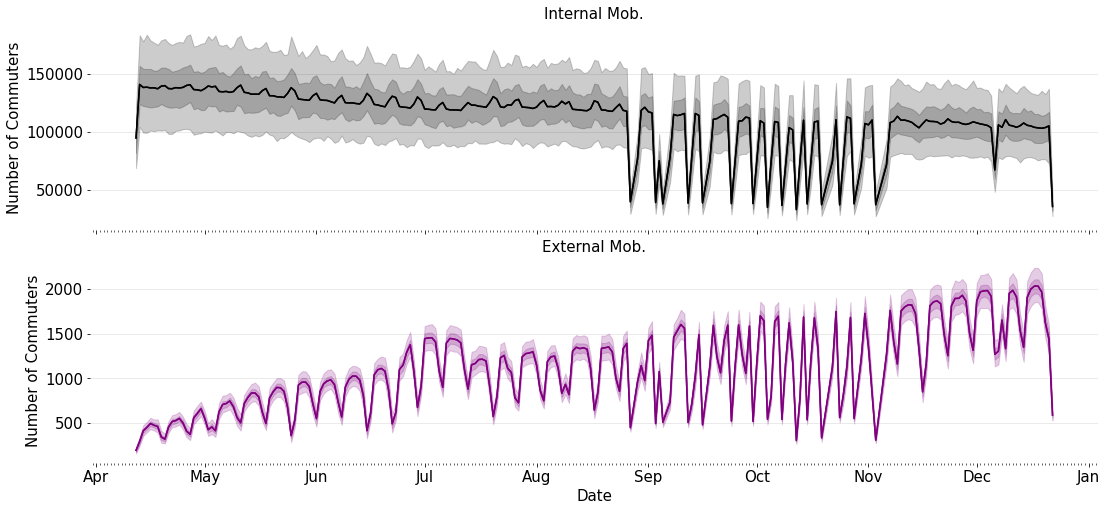

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(15.5, 7.2), sharex=True)
sns.lineplot(ax=axes[0], data=df_movement_localities[df_movement_localities.movement_type=='Internal'], x='date_time', y='movement',
                color='k', err_style='band', ci=90)#, label='Internal')
sns.lineplot(ax=axes[1], data=df_movement_localities[df_movement_localities.movement_type=='External'], x='date_time', y='movement',
                color='purple', err_style='band', ci=90)#, ,label='External')


sns.lineplot(ax=axes[0], data=df_movement_localities[df_movement_localities.movement_type=='Internal'], x='date_time', y='movement',
                color='k', err_style='band', ci=50)#, label='Internal')
sns.lineplot(ax=axes[1], data=df_movement_localities[df_movement_localities.movement_type=='External'], x='date_time', y='movement',
                color='purple', err_style='band', ci=50)#, ,label='External')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.tick_params(axis='both', labelsize=15)

axes[1].set_xlabel('Date', fontsize=15)

axes[0].set_title('Internal Mob.', fontsize=15)
axes[1].set_title('External Mob.', fontsize=15)

axes[0].set_ylabel('Number of Commuters', fontsize=15)
axes[1].set_ylabel('Number of Commuters', fontsize=15)
plt.tight_layout()

path_to_save = '/Users/chaosdonkey06/Dropbox/BIOMAC/bogota_rotating_lockdowns'
path_to_save_fig = os.path.join(path_to_save, 'figures', 'internal_external_mob.png')
fig.savefig(path_to_save_fig, dpi=300,  bbox_inches='tight', transparent=True)



In [15]:
# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code":"A",
                  "start_date" : pd.to_datetime("2020-07-13"),
                  "end_date"   : pd.to_datetime("2020-07-23"),
                  "places":["chapinero",
                            "los_martires",
                            "san_cristobal",
                            "tunjuelito",
                            "rafel_uribe_uribe",
                            "ciudad_bolivar",
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code":"B",
                  "start_date" : pd.to_datetime("2020-07-23"),
                  "end_date"   : pd.to_datetime("2020-08-06"),
                  "places":["bosa",
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code":"C",
                  "start_date" : pd.to_datetime("2020-07-31"),
                  "end_date"   : pd.to_datetime("2020-08-14"),
                  "places":["suba",
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({"code":"D",
                  "start_date" : pd.to_datetime("2020-08-16"),
                  "end_date"   : pd.to_datetime("2020-08-27"),
                  "places":["usaquen",
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})

In [16]:

dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}


df = pd.read_csv(os.path.join(results_dir,'data', 'movement_fb_locality','movement.csv'), parse_dates = ['date_time'])
df.start_poly_id = df.start_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))
df.end_poly_id = df.end_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))

# Creates type
df["movement_type"] = "External"
df.loc[df.start_poly_id  == df.end_poly_id,"movement_type"] = "Internal"
df.sample(10)


# Consolidates dataframe
d1 = df.loc[df.movement_type == "External",['date_time','start_poly_id', 'movement','movement_type']]
d1.rename(columns= {'start_poly_id':'poly_id'}, inplace = True)

d2 = df.loc[df.movement_type == "External",['date_time','end_poly_id', 'movement','movement_type']]
d2.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

d3 = df.loc[df.movement_type == "Internal",['date_time','end_poly_id', 'movement','movement_type']]
d3.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

df_movement = pd.concat((d1,d2,d3), ignore_index = True)
df_movement_all = df_movement.copy()
df_movement = df_movement.groupby(['date_time','poly_id','movement_type']).sum().reset_index()
df_movement_all

date_time         poly_id  movement movement_type
0      2020-04-12  barrios_unidos       144      External
1      2020-04-12  barrios_unidos       133      External
2      2020-04-12  barrios_unidos        47      External
3      2020-04-12  barrios_unidos       488      External
4      2020-04-12  barrios_unidos       172      External
...           ...             ...       ...           ...
132256 2020-12-22            suba     79991      Internal
132257 2020-12-22     teusaquillo     13097      Internal
132258 2020-12-22      tunjuelito     15514      Internal
132259 2020-12-22         usaquen     44766      Internal
132260 2020-12-22            usme     16146      Internal

[132261 rows x 4 columns]

In [180]:
df_movement['lockdown_type'] = 'None'

# prelockdown period
pre_lockdown_start = pd.to_datetime("2020-06-20")
pre_lockdown_end   = pd.to_datetime("2020-07-12")

lockdown_start     = pd.to_datetime("2020-07-13")
lockdown_end       = pd.to_datetime("2020-08-27")

# Assigns moments
df_movement.loc[(df_movement.date_time <= pre_lockdown_end)
            & (df_movement.date_time >= pre_lockdown_start),'lockdown_type'] = "pre-lockdown1"

df_movement.loc[(df_movement.date_time <= lockdown_end)
            & (df_movement.date_time >= lockdown_start),'lockdown_type'] = "lockdown1"



df_movement["lockdown_group"] = 'None'
df_movement["locked_down"] = False

for lock_info in lockdowns:
    g_lockdown_start     = lock_info["start_date"]
    g_lockdown_end       = lock_info["end_date"]
    df_movement.loc[ (df_movement.date_time <= g_lockdown_end)
                    & (df_movement.date_time >= g_lockdown_start), 'lockdown_group'] += "-"+lock_info["code"]


    df_movement.loc[ (df_movement.date_time <= g_lockdown_end)
                    & (df_movement.date_time >= g_lockdown_start) & (df_movement.poly_id.isin(lock_info["places"]) ), 'locked_down'] = True


df_movement["lockdown_group"] = df_movement["lockdown_group"].map(lambda x: x.split('-')[-1])
df_movement.loc[ (df_movement.date_time <= g_lockdown_end) & (df_movement.date_time >= g_lockdown_start)].head(10)

date_time         poly_id movement_type  movement lockdown_type  \
4284 2020-08-16  barrios_unidos      External     22808     lockdown1   
4285 2020-08-16  barrios_unidos      Internal     37263     lockdown1   
4286 2020-08-16            bosa      External     52082     lockdown1   
4287 2020-08-16            bosa      Internal    230879     lockdown1   
4288 2020-08-16       chapinero      External     28816     lockdown1   
4289 2020-08-16       chapinero      Internal     46532     lockdown1   
4290 2020-08-16  ciudad_bolivar      External     25857     lockdown1   
4291 2020-08-16  ciudad_bolivar      Internal    110060     lockdown1   
4292 2020-08-16        engativa      External     55358     lockdown1   
4293 2020-08-16        engativa      Internal    237038     lockdown1   

     lockdown_group  locked_down  
4284              D        False  
4285              D        False  
4286              D        False  
4287              D        False  
4288              D         True  
4289              D         True  
4290              D        False  
4291              D        False  
4292              D        False  
4293              D        False

In [183]:
mov_ext_int_df = pd.pivot_table(df_movement, values='movement', index=['date_time', 'poly_id', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['movement_type']).fillna(0).reset_index().rename(columns={'External': 'mov_ext', 'Internal': 'mov_int'})

mov_ext_int_df = mov_ext_int_df[['date_time', 'poly_id', 'lockdown_type', 'lockdown_group', "locked_down", 'mov_ext', 'mov_int']]


In [388]:
mov_ext_int_df["poly_id"] = mov_ext_int_df.poly_id.apply(lambda s: ' '.join( [word.capitalize() for word in s.split('_') ] ) )

pre_lockdown_df = mov_ext_int_df[ mov_ext_int_df["lockdown_type"] == 'pre-lockdown1' ]
A_lockdown_df   = mov_ext_int_df[ mov_ext_int_df["lockdown_group"].isin( ['A'] ) ]
B_lockdown_df   = mov_ext_int_df[ mov_ext_int_df["lockdown_group"].isin( ['B'] ) ]
C_lockdown_df   = mov_ext_int_df[ mov_ext_int_df["lockdown_group"].isin( ['C'] ) ]
D_lockdown_df   = mov_ext_int_df[ mov_ext_int_df["lockdown_group"].isin( ['D'] ) ]


In [389]:
import matplotlib
def plot_int_ext_movement(df_movement, title='', path_to_save=None):
    colors = df_movement[["poly_id", "lockdown_group", "locked_down"]].drop_duplicates().sort_values(by='poly_id')

    fig, ax = plt.subplots(1, 1, figsize=(15.5, 15.2), sharey=False)
    boxplot = df_movement[['poly_id', 'mov_ext', 'mov_int']].boxplot(ax=ax, by='poly_id', grid=False, rot=90, fontsize=15, color='k', layout=(2, 1), patch_artist=True)
    boxplot[0].set_title(f'{title} | External Movement', fontsize=15)
    boxplot[1].set_title(f'{title} | Internal Movement', fontsize=15)
    boxplot[1].set_xlabel(None)
    boxplot[1].tick_params(axis='both', labelsize=15)
    boxplot[0].get_figure().suptitle(None)

    for b in boxplot:
        for idx, p in enumerate( b.findobj(matplotlib.patches.Patch) ): # [3:5].set_facecolor("blue")
            if idx>len(colors)-1:
                break
            if colors.iloc[idx]["locked_down"]:
                p.set_facecolor("darkred")

            else:
                p.set_facecolor("white")

    plt.tight_layout()
    if path_to_save:
        fig.savefig(path_to_save, dpi=300,  bbox_inches='tight', transparent=False)

plt.show()


/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax = boxplot(
/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax = boxplot(
/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax = boxplot(
/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax = boxplot(
/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: To output multiple subplots, the figure 

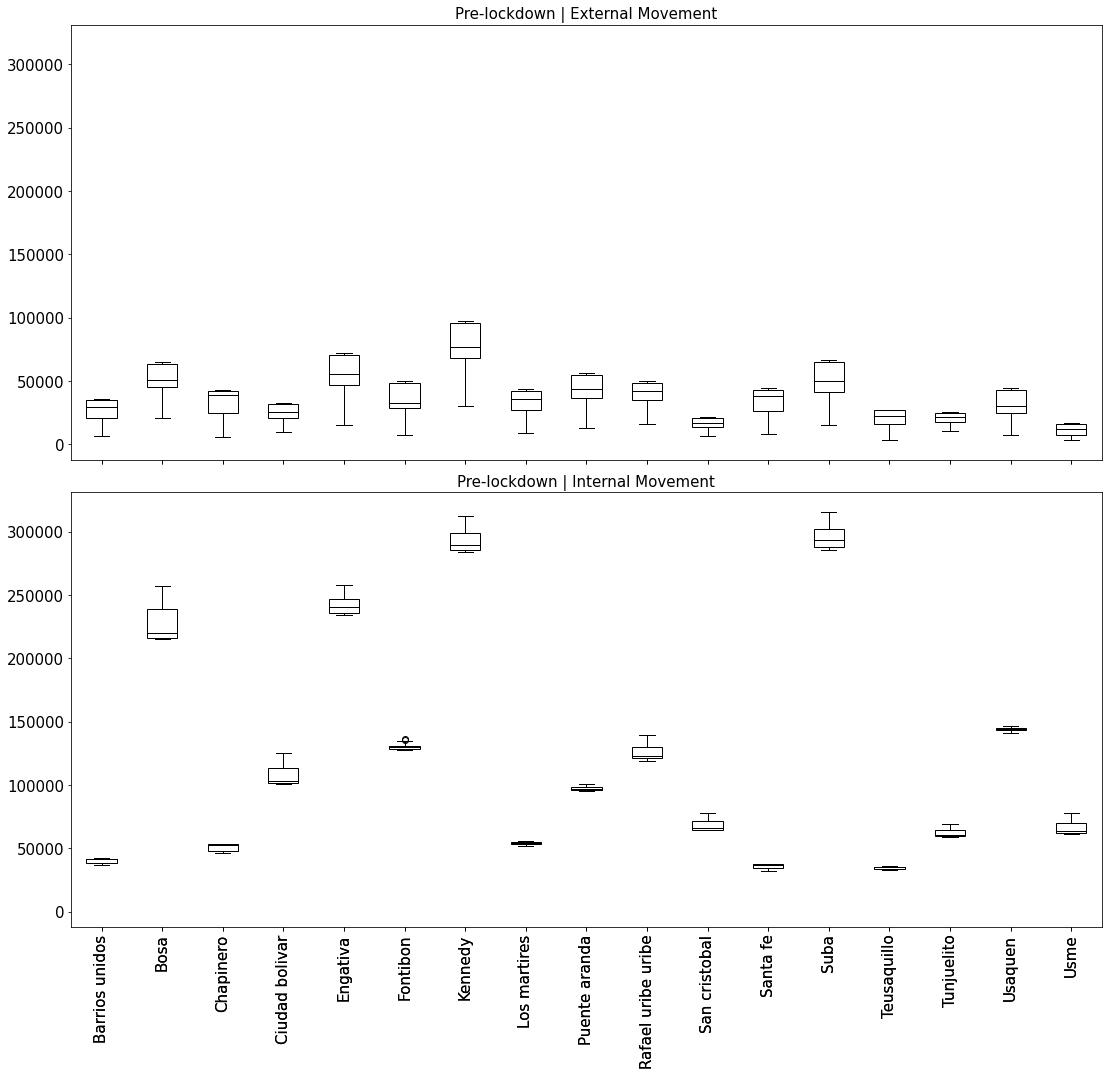

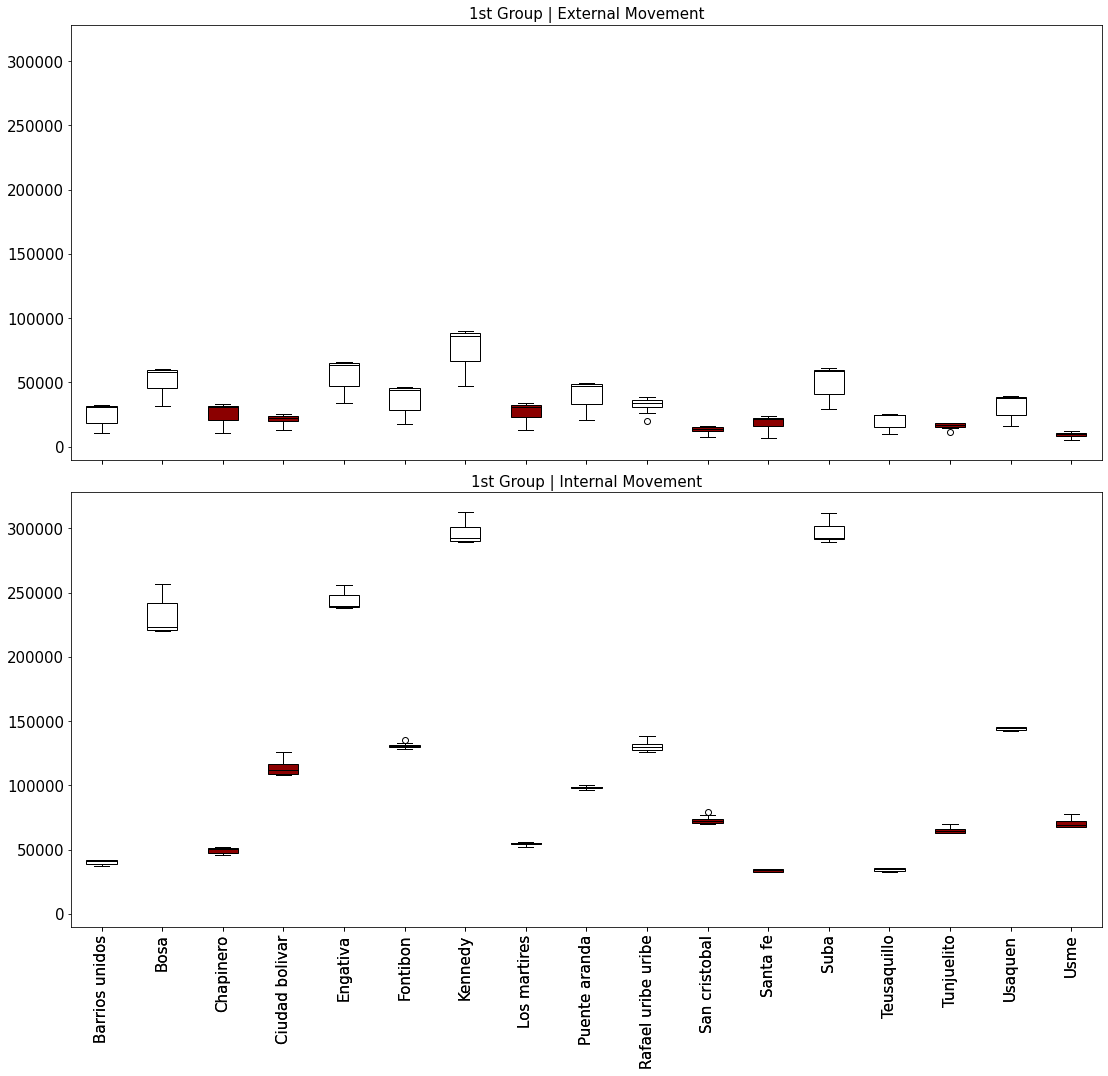

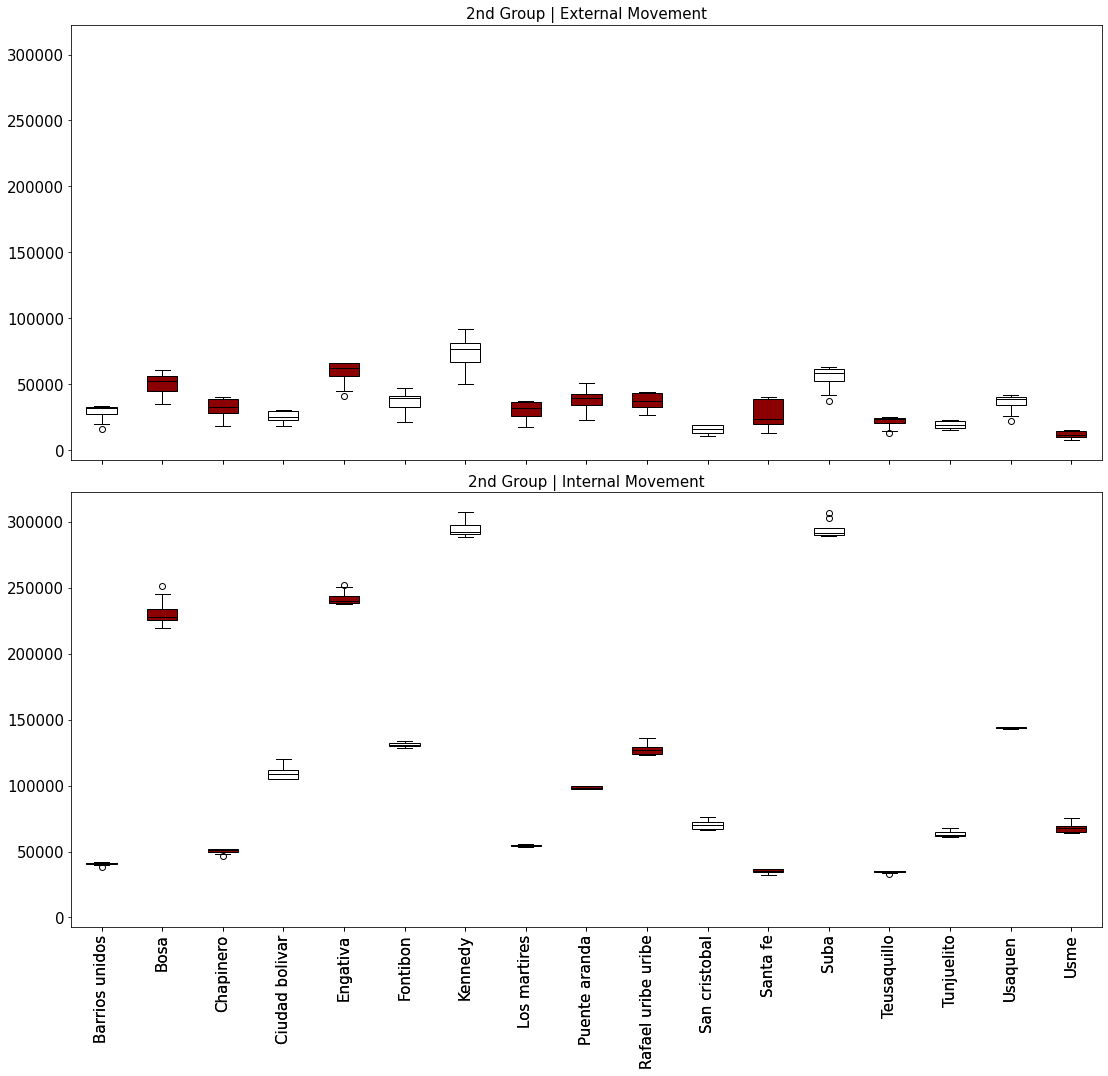

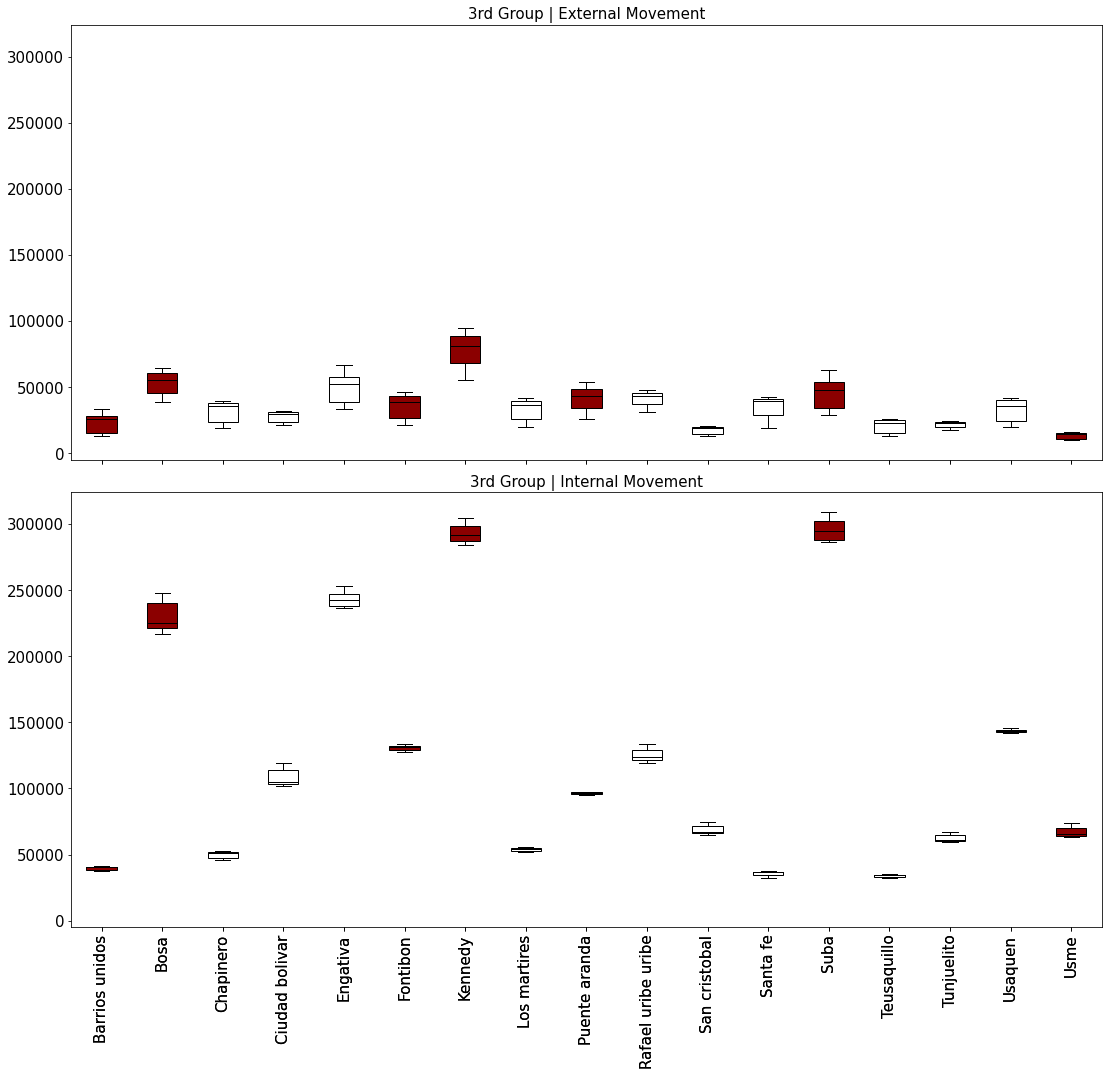

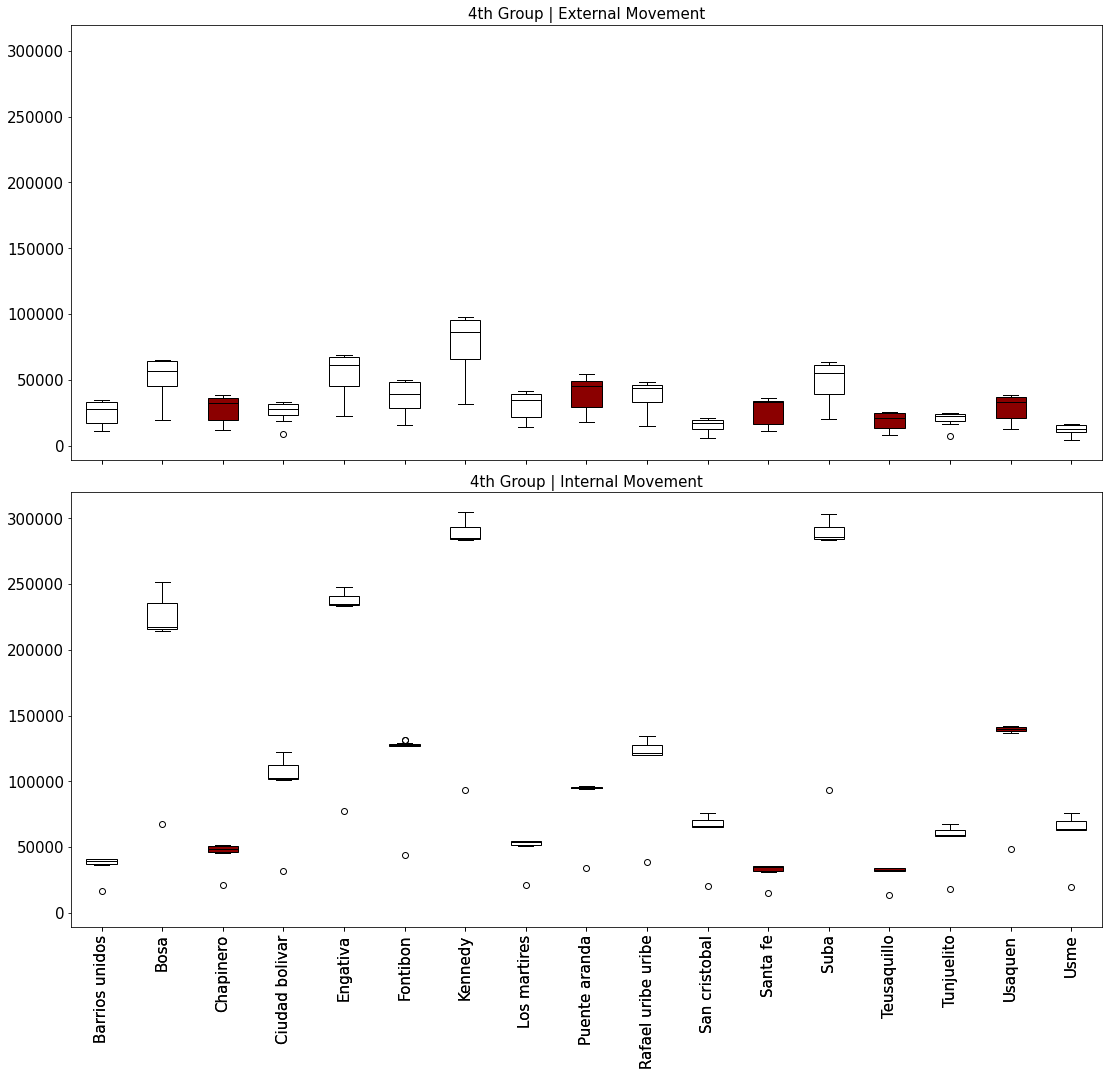

In [390]:
os.path.join(results_dir, f'data/movement_clean/internal_external_lockdown_{lock["code"]}.csv')

plot_int_ext_movement(pre_lockdown_df, title='Pre-lockdown', path_to_save=os.path.join(results_dir, 'boxplot_prelockdown.png'))
plot_int_ext_movement(A_lockdown_df, title='1st Group', path_to_save=os.path.join(results_dir, 'boxplot_A.png'))
plot_int_ext_movement(B_lockdown_df, title='2nd Group', path_to_save=os.path.join(results_dir, 'boxplot_B.png'))
plot_int_ext_movement(C_lockdown_df, title='3rd Group', path_to_save=os.path.join(results_dir, 'boxplot_C.png'))
plot_int_ext_movement(D_lockdown_df, title='4th Group', path_to_save=os.path.join(results_dir, 'boxplot_D.png'))



In [469]:
NUM_COLORS = len(loc_poly_df)
cm = pylab.get_cmap('gist_ncar')
color_l = [cm(1.*idx/NUM_COLORS) for idx in range(NUM_COLORS)]

loc_poly_df["color"] = color_l
loc_poly_df

poly_id           poly_name  \
0         colombia_bogota_localidad_los_martires        Los Martires   
1             colombia_bogota_localidad_fontibon            Fontibon   
2   colombia_bogota_localidad_rafael_uribe_uribe  Rafael Uribe Uribe   
3              colombia_bogota_localidad_usaquen             Usaquen   
4           colombia_bogota_localidad_tunjuelito          Tunjuelito   
5       colombia_bogota_localidad_ciudad_bolivar      Ciudad Bolivar   
6        colombia_bogota_localidad_san_cristobal       San Cristobal   
7          colombia_bogota_localidad_teusaquillo         Teusaquillo   
8                 colombia_bogota_localidad_bosa                Bosa   
9                 colombia_bogota_localidad_usme                Usme   
10      colombia_bogota_localidad_antonio_narino      Antonio Nariño   
11                colombia_bogota_localidad_suba                Suba   
12       colombia_bogota_localidad_puente_aranda       Puente Aranda   
13            colombia_bogota_localidad_santa_fe            Santa Fe   
14          colombia_bogota_localidad_candelaria          Candelaria   
15             colombia_bogota_localidad_kennedy             Kennedy   
16      colombia_bogota_localidad_barrios_unidos      Barrios Unidos   
17            colombia_bogota_localidad_engativa            Engativa   
18           colombia_bogota_localidad_chapinero           Chapinero   

                                             geometry  \
0   POLYGON ((-74.07296 4.61558, -74.07283 4.61542...   
1   POLYGON ((-74.15845 4.66267, -74.15857 4.66274...   
2   POLYGON ((-74.12829 4.59265, -74.12803 4.59254...   
3   POLYGON ((-74.01094 4.66457, -74.01116 4.66459...   
4   POLYGON ((-74.14043 4.59536, -74.13777 4.59489...   
5   POLYGON ((-74.21092 4.38691, -74.21092 4.38691...   
6   POLYGON ((-74.02892 4.55857, -74.02900 4.55830...   
7   POLYGON ((-74.10342 4.65351, -74.09372 4.66607...   
8   POLYGON ((-74.18568 4.64705, -74.18567 4.64705...   
9   POLYGON ((-74.05599 4.50834, -74.05597 4.50832...   
10  POLYGON ((-74.13075 4.59335, -74.13075 4.59335...   
11  POLYGON ((-74.03489 4.82552, -74.03450 4.82547...   
12  POLYGON ((-74.11845 4.63727, -74.11830 4.63741...   
13  POLYGON ((-73.99446 4.61425, -73.99446 4.61425...   
14  POLYGON ((-74.06621 4.60317, -74.06621 4.60317...   
15  POLYGON ((-74.18480 4.64497, -74.18567 4.64705...   
16  POLYGON ((-74.05725 4.68684, -74.05725 4.68684...   
17  POLYGON ((-74.15547 4.71798, -74.15547 4.71798...   
18  POLYGON ((-74.01117 4.66460, -74.01116 4.66459...   

                                                color    poly_name_format  
0                              (0.0, 0.0, 0.502, 1.0)        los_martires  
1   (0.0, 0.3720569011918493, 0.02238446751249512,...            fontibon  
2   (0.0, 0.02670630379656419, 0.8696397092170203,...  rafael_uribe_uribe  
3                 (0.0, 0.7196739023452516, 1.0, 1.0)             usaquen  
4   (0.0, 0.9653681814686658, 0.9741483093237298, ...          tunjuelito  
5              (0.0, 0.9804, 0.6140294949898466, 1.0)      ciudad_bolivar  
6   (0.02499917440660453, 0.9983842469753859, 0.08...       san_cristobal  
7   (0.37463797729618165, 0.8081894370651488, 0.0,...         teusaquillo  
8   (0.49259200307574014, 0.9742868437697659, 0.01...                bosa  
9   (0.7324457105610915, 1.0, 0.23416095104708531,...                usme  
10  (0.9644575681274331, 0.990405600200007, 0.0311...      antonio_narino  
11                (1.0, 0.8550007643130112, 0.0, 1.0)                suba  
12  (1.0, 0.7292677024179433, 0.054870449826989715...       puente_aranda  
13  (1.0, 0.27980875031251173, 0.00366512605042017...            santa_fe  
14               (1.0, 0.03730424169667851, 0.0, 1.0)          candelaria  
15                (1.0, 0.0, 0.9730348441015754, 1.0)             kennedy  
16  (0.6490989106753807, 0.17552034001214337, 0.99...      barrios_unidos  
17  (0.9235279123414071, 0.5001816608996538, 0.934...            engativa  
18  (0.95981395

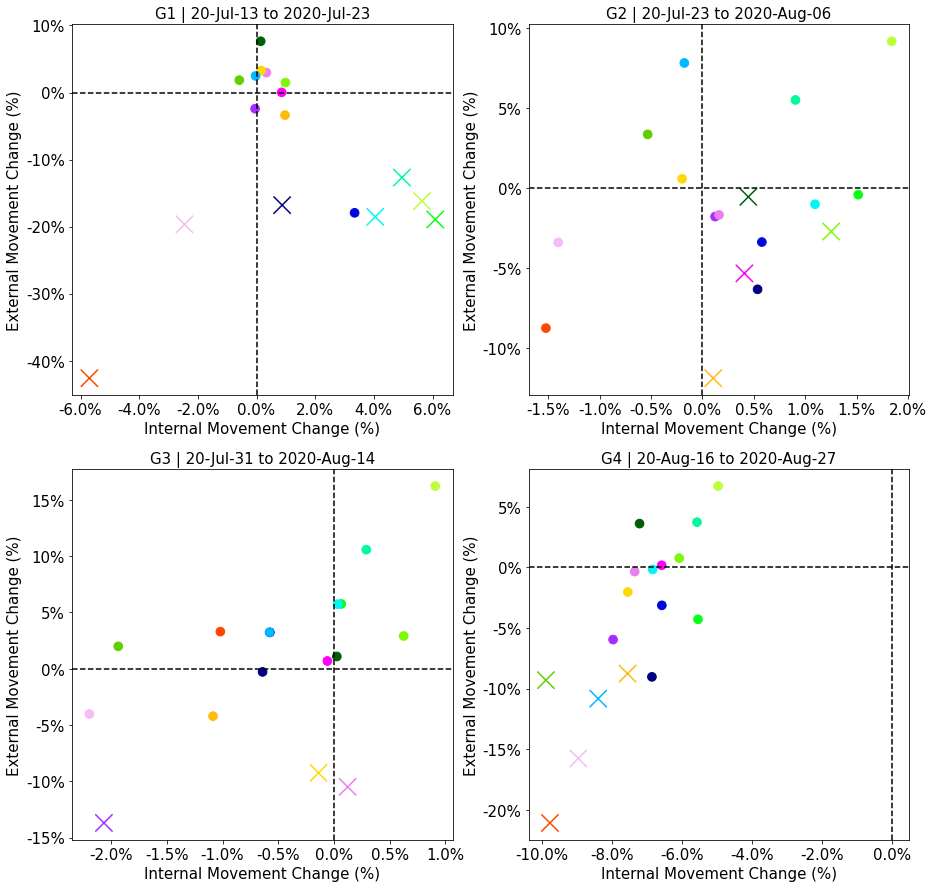

In [487]:
codes_names = ['G1', 'G2', 'G3', 'G4']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for idx, ax in enumerate(axes.flatten()):
    duration = (pd.to_datetime(lock['end_date']) - pd.to_datetime(lock['start_date'])).days
    lock = lockdowns[idx]
    lockdown_start = pd.to_datetime(lock['start_date'])
    lockdown_end   = pd.to_datetime(lock['end_date'])

    # Filter by date
    df_temp = df_movement.copy()
    df_temp['moment'] = None

    # Assigns moments
    df_temp.loc[(df_movement.date_time <= pre_lockdown_end)
                & (df_movement.date_time >= pre_lockdown_start),'moment'] = "Pre-Lockdown"

    df_temp.loc[(df_movement.date_time <= lockdown_end)
                & (df_movement.date_time >= lockdown_start),'moment'] = "Lockdown"

    # Filters
    df_temp = df_temp[~df_temp.moment.isna()].copy()

    # Then by week
    df_temp = df_temp[["poly_id","moment","movement_type","movement"]].groupby(["poly_id","moment","movement_type"]).mean().reset_index()

    df_temp = df_temp.pivot_table(index = ['poly_id'], columns=["moment","movement_type"], values = ['movement']).reset_index()
    #df_temp.columns = ["poly_id",'moment',"external_movement","internal_movement"]

    df_temp['external_change'] = 100*(df_temp.movement.Lockdown.External -  df_temp.movement["Pre-Lockdown"].External)/df_temp.movement["Pre-Lockdown"].External
    df_temp['internal_change'] = 100*(df_temp.movement.Lockdown.Internal -  df_temp.movement["Pre-Lockdown"].Internal)/df_temp.movement["Pre-Lockdown"].Internal
    df_temp['all_change']      = 100*((df_temp.movement.Lockdown.Internal + df_temp.movement.Lockdown.External) - (df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External))/(df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External)
    df_temp['locality_type']   =  no_lock_lab
    df_temp["locality_type"]   = [ int(i) * lock_lab +  (1-int(i)) * no_lock_lab for i in df_temp.poly_id.isin(lock['places']).to_list() ]
    df_temp['color']           = df_temp["poly_id"].map(lambda x: loc_poly_df[loc_poly_df.poly_name_format == x]["color"].values[0])

    no_lockdown_df = df_temp[df_temp.locality_type=='No Lockdown Imposed']
    lockdown_df    = df_temp[df_temp.locality_type=='Lockdown Imposed']

    ax.scatter(x= no_lockdown_df.internal_change, y=no_lockdown_df.external_change, color=no_lockdown_df.color, s=300, marker='.')
    ax.scatter(x= lockdown_df.internal_change, y=lockdown_df.external_change, color=lockdown_df.color, s=300, marker='x')
    ax.tick_params(axis='both', labelsize=15)


    ax.set_xlabel('Internal Movement Change (%)', fontsize=15)
    ax.set_ylabel('External Movement Change (%)', fontsize=15)
    ax.set_title(f"{codes_names[idx]} | {lock['start_date'].strftime('%y-%b-%d')} to {lock['end_date'].strftime('%Y-%b-%d')}", fontsize=15)
    ax.axhline(y=0, linestyle='--', color='k')
    ax.axvline(x=0, linestyle='--', color='k')
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}%"))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}%"))

path_to_save = os.path.join(results_dir, 'percentage_change.png')
fig.savefig(path_to_save, bbox_inches='tight', dpi=300, transparent=True)


In [460]:
lock = lockdowns[0]
duration = (pd.to_datetime(lock['end_date']) - pd.to_datetime(lock['start_date'])).days

lockdown_start = pd.to_datetime(lock['start_date'])
lockdown_end = pd.to_datetime(lock['end_date'])

# Filter by date
df_temp = df_movement.copy()

df_temp['moment'] = None

# Assigns moments
df_temp.loc[(df_movement.date_time <= pre_lockdown_end) 
            & (df_movement.date_time >= pre_lockdown_start),'moment'] = "Pre-Lockdown"

df_temp.loc[(df_movement.date_time <= lockdown_end) 
            & (df_movement.date_time >= lockdown_start),'moment'] = "Lockdown"

# Filters
df_temp = df_temp[~df_temp.moment.isna()].copy()


# Then by week
df_temp = df_temp[["poly_id","moment","movement_type","movement"]].groupby(["poly_id","moment","movement_type"]).mean().reset_index()
df_temp = df_temp.pivot_table(index = ['poly_id'], columns=["moment","movement_type"], values = ['movement']).reset_index()
#df_temp.columns = ["poly_id",'moment',"external_movement","internal_movement"]

df_temp['external_change'] = 100*(df_temp.movement.Lockdown.External -  df_temp.movement["Pre-Lockdown"].External)/df_temp.movement["Pre-Lockdown"].External
df_temp['internal_change'] = 100*(df_temp.movement.Lockdown.Internal -  df_temp.movement["Pre-Lockdown"].Internal)/df_temp.movement["Pre-Lockdown"].Internal
df_temp['all_change'] = 100*((df_temp.movement.Lockdown.Internal + df_temp.movement.Lockdown.External) - (df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External))/(df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External)
df_temp['locality_type'] =  no_lock_lab
df_temp["locality_type"] = [ int(i) * lock_lab +  (1-int(i)) * no_lock_lab for i in df_temp.poly_id.isin(lock['places']).to_list() ] 




poly_id           poly_name  \
0         colombia_bogota_localidad_los_martires        Los Martires   
1             colombia_bogota_localidad_fontibon            Fontibon   
2   colombia_bogota_localidad_rafael_uribe_uribe  Rafael Uribe Uribe   
3              colombia_bogota_localidad_usaquen             Usaquen   
4           colombia_bogota_localidad_tunjuelito          Tunjuelito   
5       colombia_bogota_localidad_ciudad_bolivar      Ciudad Bolivar   
6        colombia_bogota_localidad_san_cristobal       San Cristobal   
7          colombia_bogota_localidad_teusaquillo         Teusaquillo   
8                 colombia_bogota_localidad_bosa                Bosa   
9                 colombia_bogota_localidad_usme                Usme   
10      colombia_bogota_localidad_antonio_narino      Antonio Nariño   
11                colombia_bogota_localidad_suba                Suba   
12       colombia_bogota_localidad_puente_aranda       Puente Aranda   
13            colombia_bogota_localidad_santa_fe            Santa Fe   
14          colombia_bogota_localidad_candelaria          Candelaria   
15             colombia_bogota_localidad_kennedy             Kennedy   
16      colombia_bogota_localidad_barrios_unidos      Barrios Unidos   
17            colombia_bogota_localidad_engativa            Engativa   
18           colombia_bogota_localidad_chapinero           Chapinero   

                                             geometry  \
0   POLYGON ((-74.07296 4.61558, -74.07283 4.61542...   
1   POLYGON ((-74.15845 4.66267, -74.15857 4.66274...   
2   POLYGON ((-74.12829 4.59265, -74.12803 4.59254...   
3   POLYGON ((-74.01094 4.66457, -74.01116 4.66459...   
4   POLYGON ((-74.14043 4.59536, -74.13777 4.59489...   
5   POLYGON ((-74.21092 4.38691, -74.21092 4.38691...   
6   POLYGON ((-74.02892 4.55857, -74.02900 4.55830...   
7   POLYGON ((-74.10342 4.65351, -74.09372 4.66607...   
8   POLYGON ((-74.18568 4.64705, -74.18567 4.64705...   
9   POLYGON ((-74.05599 4.50834, -74.05597 4.50832...   
10  POLYGON ((-74.13075 4.59335, -74.13075 4.59335...   
11  POLYGON ((-74.03489 4.82552, -74.03450 4.82547...   
12  POLYGON ((-74.11845 4.63727, -74.11830 4.63741...   
13  POLYGON ((-73.99446 4.61425, -73.99446 4.61425...   
14  POLYGON ((-74.06621 4.60317, -74.06621 4.60317...   
15  POLYGON ((-74.18480 4.64497, -74.18567 4.64705...   
16  POLYGON ((-74.05725 4.68684, -74.05725 4.68684...   
17  POLYGON ((-74.15547 4.71798, -74.15547 4.71798...   
18  POLYGON ((-74.01117 4.66460, -74.01116 4.66459...   

                                                color    poly_name_format  
0                              (0.0, 0.0, 0.502, 1.0)        los_martires  
1   (0.0, 0.3720569011918493, 0.02238446751249512,...            fontibon  
2   (0.0, 0.02670630379656419, 0.8696397092170203,...  rafael_uribe_uribe  
3                 (0.0, 0.7196739023452516, 1.0, 1.0)             usaquen  
4   (0.0, 0.9653681814686658, 0.9741483093237298, ...          tunjuelito  
5              (0.0, 0.9804, 0.6140294949898466, 1.0)      ciudad_bolivar  
6   (0.02499917440660453, 0.9983842469753859, 0.08...       san_cristobal  
7   (0.37463797729618165, 0.8081894370651488, 0.0,...         teusaquillo  
8   (0.49259200307574014, 0.9742868437697659, 0.01...                bosa  
9   (0.7324457105610915, 1.0, 0.23416095104708531,...                usme  
10  (0.9644575681274331, 0.990405600200007, 0.0311...      antonio_narino  
11                (1.0, 0.8550007643130112, 0.0, 1.0)                suba  
12  (1.0, 0.7292677024179433, 0.054870449826989715...       puente_aranda  
13  (1.0, 0.27980875031251173, 0.00366512605042017...            santa_fe  
14               (1.0, 0.03730424169667851, 0.0, 1.0)          candelaria  
15                (1.0, 0.0, 0.9730348441015754, 1.0)             kennedy  
16  (0.6490989106753807, 0.17552034001214337, 0.99...      barrios_unidos  
17  (0.9235279123414071, 0.5001816608996538, 0.934...            engativa  
18  (0.95981395

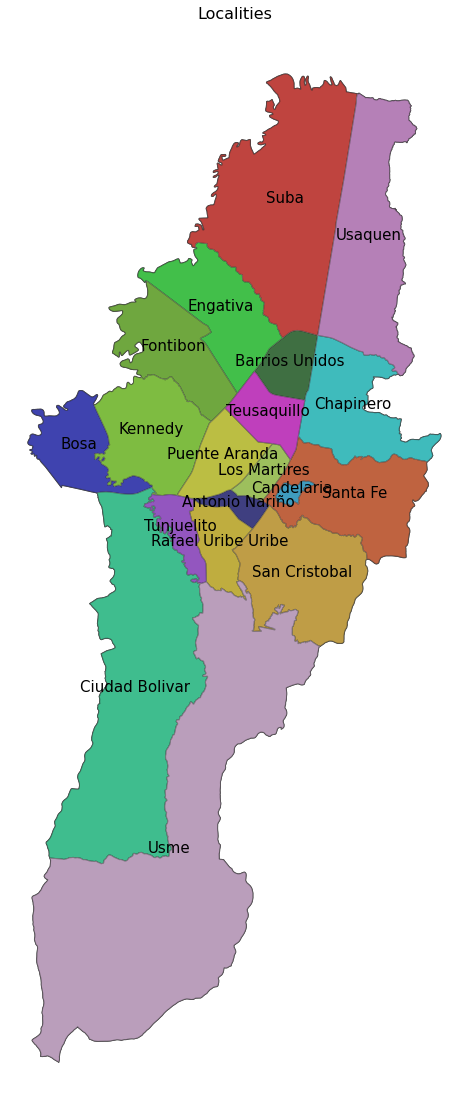

In [488]:
from matplotlib import transforms
import pylab


def plot_bog_specified_column(df_polygons, title, col_name='value', cmap = 'seismic_r', labels = True, path_to_save = None):
    rot = transforms.Affine2D().rotate_deg(90)

    NUM_COLORS = len(df_polygons)
    cm = pylab.get_cmap('gist_ncar')
    color_l = [cm(1.*idx/NUM_COLORS) for idx in range(NUM_COLORS)]


    df_polygons = df_polygons.sort_values(by=col_name)
    fig, ax = plt.subplots(1,1, figsize=(10, 20))

    base = ax.figure.gca().transData
    rot = transforms.Affine2D().rotate_deg(90)

    maps1 = df_polygons.plot(ax=ax, edgecolor='black', alpha=1, facecolor='Grey', linewidth=1)
    maps2 = df_polygons.plot(ax=ax, edgecolor='gray',  facecolor=color_l, alpha=0.5, linewidth=1) 

    # Plot values as linestring
    ax.set_title(title, fontsize = 16)
    ax.set_axis_off()

    if labels:
        df_polygons.apply(lambda p: ax.text(s=p[col_name], x=p.geometry.centroid.coords[0][0], y = p.geometry.centroid.coords[0][1], ha='center', fontsize=15), axis=1)

    if path_to_save:
        fig.savefig(path_to_save, bbox_inches='tight', dpi=300, transparent=True)

path_to_save = os.path.join(results_dir, 'qual_map.png')

plot_bog_specified_column(loc_poly_df, title='Localities', col_name='poly_name', labels = True, path_to_save = path_to_save)

In [326]:
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist
import pyro.optim as optim
import pyro
import torch

df_temp_lockdown   = df_temp[df_temp.locality_type=='Lockdown Imposed'][["poly_id", "external_change", "internal_change"]]
df_temp_nolockdown = df_temp[df_temp.locality_type=='No Lockdown Imposed']


def model( int_mov_change, ext_mov_change):
    b0 = pyro.sample("b0", dist.Normal(0., 1.))
    b1 = pyro.sample("b1", dist.Normal(0, 10))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = b0 + b1 * int_mov_change

    with pyro.plate("data", len(ext_mov_change)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=ext_mov_change)

def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run( torch.tensor(df_temp_lockdown.internal_change.values, dtype=torch.float), torch.tensor(df_temp_lockdown.external_change.values) )

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


Sample: 100%|██████████| 1200/1200 [00:13, 89.96it/s, step size=6.69e-01, acc. prob=0.912]


/Users/chaosdonkey06/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chaosdonkey06/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chaosdonkey06/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

Text(0.5, 1.0, '$\\sigma$')

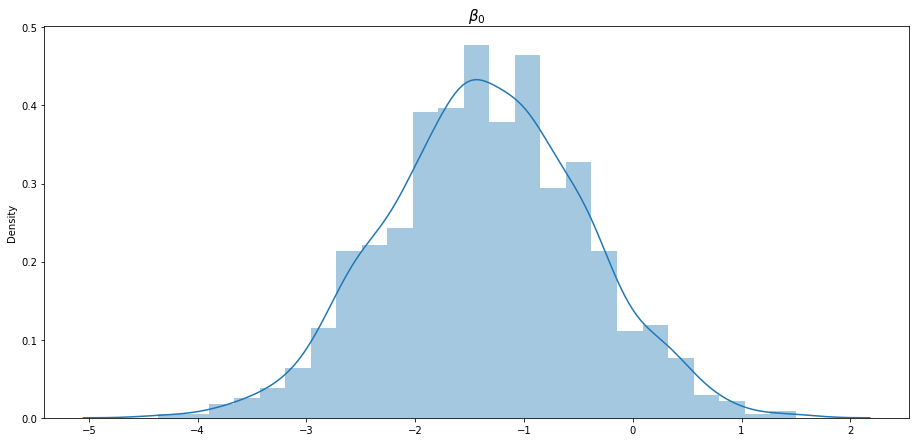

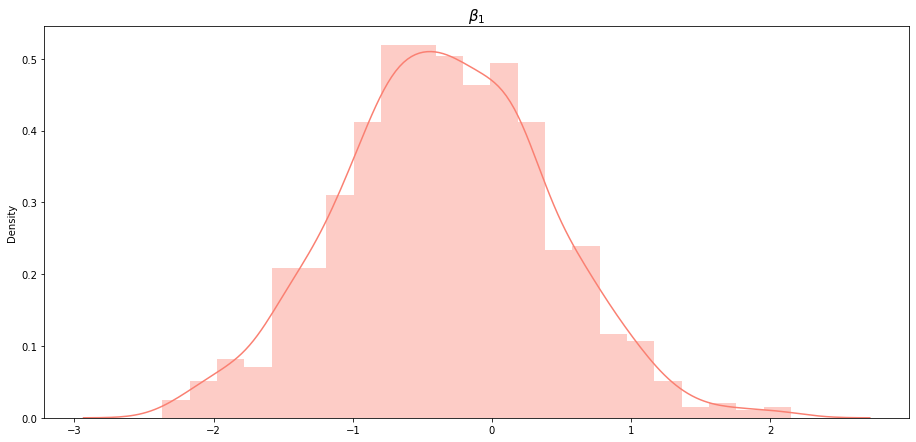

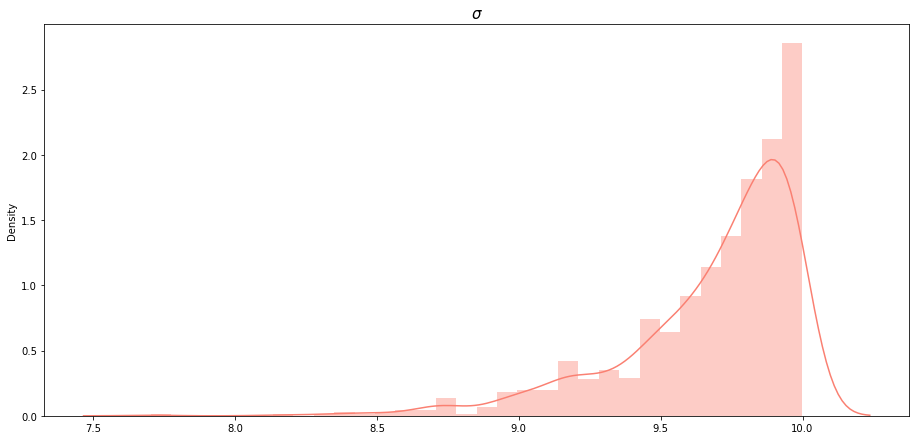

In [385]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(15.5, 7.2))

sns.distplot(ax=ax, a=hmc_samples['b0'])
ax.set_title(r'$\beta_0$', fontsize=15)

fig, ax = plt.subplots(1,1, figsize=(15.5, 7.2))
sns.distplot(ax=ax, a=hmc_samples['b1'], color='salmon')
ax.set_title(r'$\beta_1$', fontsize=15)

fig, ax = plt.subplots(1,1, figsize=(15.5, 7.2))
sns.distplot(ax=ax, a=hmc_samples['sigma'], color='salmon')
ax.set_title(r'$\sigma$', fontsize=15)

In [382]:
from pyro.infer import Predictive

pred_model   = Predictive(model, posterior_samples=hmc_samples, num_samples=800)
pred_samples = pred_model()



TypeError: model() missing 2 required positional arguments: 'int_mov_change' and 'ext_mov_change'

In [383]:
pred_samples['obs']

tensor([[-19.6551, -12.6823, -16.7952,  ..., -42.6078, -18.5306, -16.1820],
        [-19.6551, -12.6823, -16.7952,  ..., -42.6078, -18.5306, -16.1820],
        [-19.6551, -12.6823, -16.7952,  ..., -42.6078, -18.5306, -16.1820],
        ...,
        [-19.6551, -12.6823, -16.7952,  ..., -42.6078, -18.5306, -16.1820],
        [-19.6551, -12.6823, -16.7952,  ..., -42.6078, -18.5306, -16.1820],
        [-19.6551, -12.6823, -16.7952,  ..., -42.6078, -18.5306, -16.1820]])

In [380]:
marginal_site = pd.DataFrame(pred_samples['obs'].numpy())
marginal_site

0          1          2          3          4          5  \
0   -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
1   -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
2   -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
3   -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
4   -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
..        ...        ...        ...        ...        ...        ...   
995 -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
996 -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
997 -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
998 -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   
999 -19.65513 -12.682296 -16.795155 -18.931826 -42.607834 -18.530634   

             6  
0   -16.182022  
1   -16.182022  
2   -16.182022  
3   -16.182022  
4   -16.182022  
..         ...  
995 -16.182022  
996 -16.182022  
997 -16.182022  
998 -16.182022  
999 -16.182022  

[1000 rows x 7 columns]

In [371]:

df_temp_lockdown.index.values


array([ 2,  3,  7, 10, 11, 14, 16])

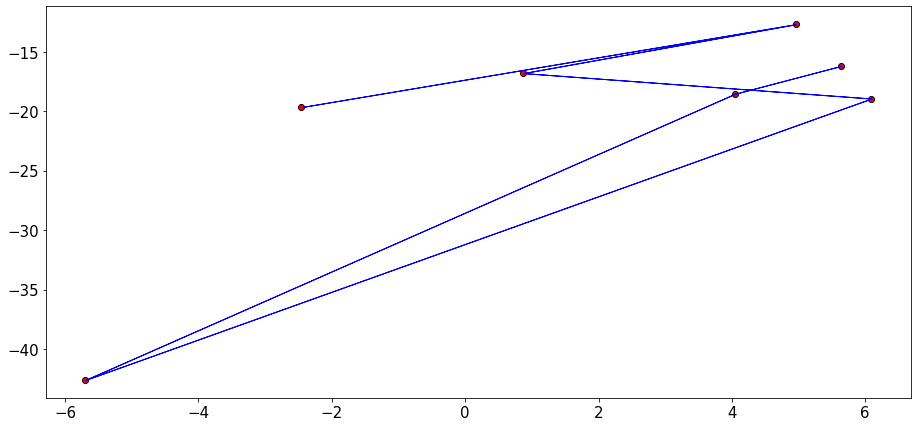

In [379]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))
ax.scatter(df_temp_lockdown.internal_change.values, df_temp_lockdown.external_change.values, facecolor='red', edgecolor='k')

ax.fill_between(df_temp_lockdown.internal_change.values, describe.iloc[0], describe.iloc[-1], color='blue')

ax.tick_params(axis='both', labelsize=15)


In [375]:
df_temp_lockdown.internal_change.values

array([-2.45602065,  4.95705115,  0.87344478,  6.09256426, -5.6987611 ,
        4.04816338,  5.64214857])

In [376]:
df_temp_lockdown.iloc[0]

poly_id            chapinero
external_change     -19.6551
internal_change     -2.45602
Name: 2, dtype: object